<a name="top"></a>
<img src="https://netacad.centralesupelec.fr/img/cs.jpg" width="200" style="display:inline;">
<img src="static/Blanc.png" width="500" style="display:inline;">
<img src="static/Airbnb_Logo.png" width="200" style="display:inline;">

<h1>
<center>Airbnb price prediction</center>
</h1>

---


<center>
<nav>
<a href="https://github.com/flaviendeseure/Airbnb_berlin_price_prediction">Github</a> |
<a href="https://centralesupelec.edunao.com/course/view.php?id=5285">CentraleSupélec</a>
</nav>
</center>

## About the project
---
This project aims to predict the price of a night's accommodation offered on the short-term rental website Airbnb in the city of Berlin.

## *Table of Contents*
- [Utils](#utils)
    - [Imports](#imports)
    - [Helper Functions](#helper_functions)
- [Exploratory Data Analysis](#eda)
    - [Global analysis](#general_analysis)
    - [Feature analysis](#analysis_per_col)
    - [Target analysis](#target_analysis)
    - [Conclusion analysis](#conclusion)
- [Preprocessing](#preprocessing)
    - [Split](#split)
    - [Missing values](#missing_values)
    - [Scaling](#scaling)
    - [Outliers](#outliers)
    - [Categorical features](#cat_feat)
    - [Feature engineering](#feature_eng)
- [Modeling](#modeling)
    - [Feature selection](#feature_selection)
    - [Model selection](#model_selection)
- [Scoring](#scoring)

<a name="utils">

## Utils
---

<a name="imports">

### Imports

In [1]:
# Utils
## System
import os
# Data
import pandas as pd
import numpy as np

# Exploratory analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
## Split data
from sklearn.model_selection import train_test_split
## Missing values
## Scaling
## Outliers
## Categorical features
import category_encoders as ce
## Feature engineering

# Modeling
## Sklearn models
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
## XGboost models
from xgboost.sklearn import XGBRegressor
## Lightgbm models
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import explained_variance_score, r2_score , mean_squared_error, mean_absolute_error

In [2]:
# Options
pd.set_option('display.max_columns', 40)
sns.set_theme(style="white")

<a href="#top">back to top</a>

<a name="helper_functions">

### Helper Functions

#### Exploratory analysis

In [30]:
def missing_values_rate_display(col_name, dataset):
    missing_values_sum = dataset[col_name].isna().sum()
    missing_value_rate = missing_values_sum/dataset.shape[0]
    print(f"Missing value for {col_name} columns: {100*missing_value_rate:.3f}% ({missing_values_sum}/{dataset.shape[0]})")
    
def display_corr_matrix(corr_mat):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

#### Preprocessing

#### Modeling

In [4]:
def forward(features):
    # Pull out features we still need to process
    remaining_features = [d for d in X.columns if d not in features]
    
    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward(features):
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

<a href="#top">back to top</a>

<a name="importdata">

## Exploratory Data Analysis
---

<a name="importdata">
    
### Import data

In [5]:
DATA_DIR = "data"
DATA_FILE = "train_airbnb_berlin.csv"
PATH_DATA = os.path.join(DATA_DIR, DATA_FILE)
dataset = pd.read_csv(PATH_DATA)
dataset.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Square Feet,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10437.0,DE,Germany,52.54652,13.41792,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,6,2017-07-07,2017-08-08,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,Berlin,13187.0,DE,Germany,52.56512,13.42214,t,Apartment,Entire home/apt,2,1.0,2.0,2.0,NaN,2,7,6,2015-05-26,2019-04-30,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10439.0,DE,Germany,52.54741,13.42521,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,NaN,1,1,2,2016-04-19,2016-07-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10245,DE,Germany,52.50958,13.45144,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,4,2018-07-31,2018-08-12,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,Berlin,10405.0,DE,Germany,52.52995,13.41558,t,Apartment,Private room,3,1.0,1.0,2.0,NaN,1,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


In [6]:
X = dataset.drop("Price", axis=1)
y = dataset["Price"]

<a href="#top">back to top</a>

<a name="general_analysis">
    
### Global analysis

In [7]:
X.columns

Index(['Listing ID', 'Listing Name', 'Host ID', 'Host Name', 'Host Since',
       'Host Response Time', 'Host Response Rate', 'Is Superhost',
       'neighbourhood', 'Neighborhood Group', 'City', 'Postal Code',
       'Country Code', 'Country', 'Latitude', 'Longitude', 'Is Exact Location',
       'Property Type', 'Room Type', 'Accomodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Square Feet', 'Guests Included', 'Min Nights', 'Reviews',
       'First Review', 'Last Review', 'Overall Rating', 'Accuracy Rating',
       'Cleanliness Rating', 'Checkin Rating', 'Communication Rating',
       'Location Rating', 'Value Rating', 'Instant Bookable',
       'Business Travel Ready'],
      dtype='object')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15692 entries, 0 to 15691
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Listing ID             15691 non-null  float64
 1   Listing Name           15638 non-null  object 
 2   Host ID                15692 non-null  float64
 3   Host Name              15670 non-null  object 
 4   Host Since             15671 non-null  object 
 5   Host Response Time     8617 non-null   object 
 6   Host Response Rate     8617 non-null   object 
 7   Is Superhost           15669 non-null  object 
 8   neighbourhood          15692 non-null  object 
 9   Neighborhood Group     15692 non-null  object 
 10  City                   15691 non-null  object 
 11  Postal Code            15463 non-null  object 
 12  Country Code           15692 non-null  object 
 13  Country                15692 non-null  object 
 14  Latitude               15692 non-null  float64
 15  Lo

In [9]:
dataset.describe()

,Listing ID,Host ID,Latitude,Longitude,Square Feet,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price
count,1.569100e+04,1.569200e+04,15692.000000,15692.000000,303.000000,15692.000000,12730.000000,12721.000000,12722.000000,12719.000000,12722.000000,12721.000000,12720.000000,15683.000000
mean,1.780062e+07,6.119042e+07,52.509893,13.407334,445.900990,19.452014,94.717282,9.717475,9.328407,9.769164,9.779201,9.556874,9.458097,60.342983
std,9.952544e+06,6.739421e+07,0.031286,0.058646,414.817342,39.483853,7.069787,0.671793,1.023807,0.620347,0.619545,0.731109,0.788891,48.829687
min,2.241500e+04,1.101500e+04,52.369270,13.121400,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000
25%,9.052831e+06,9.274528e+06,52.488920,13.376025,0.000000,1.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000
50%,1.865037e+07,3.358182e+07,52.509100,13.417250,440.000000,5.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000
75%,2.611308e+07,9.325677e+07,52.532713,13.439750,700.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,70.000000
max,3.467450e+07,2.609698e+08,52.639670,13.709020,1912.000000,424.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,900.000000


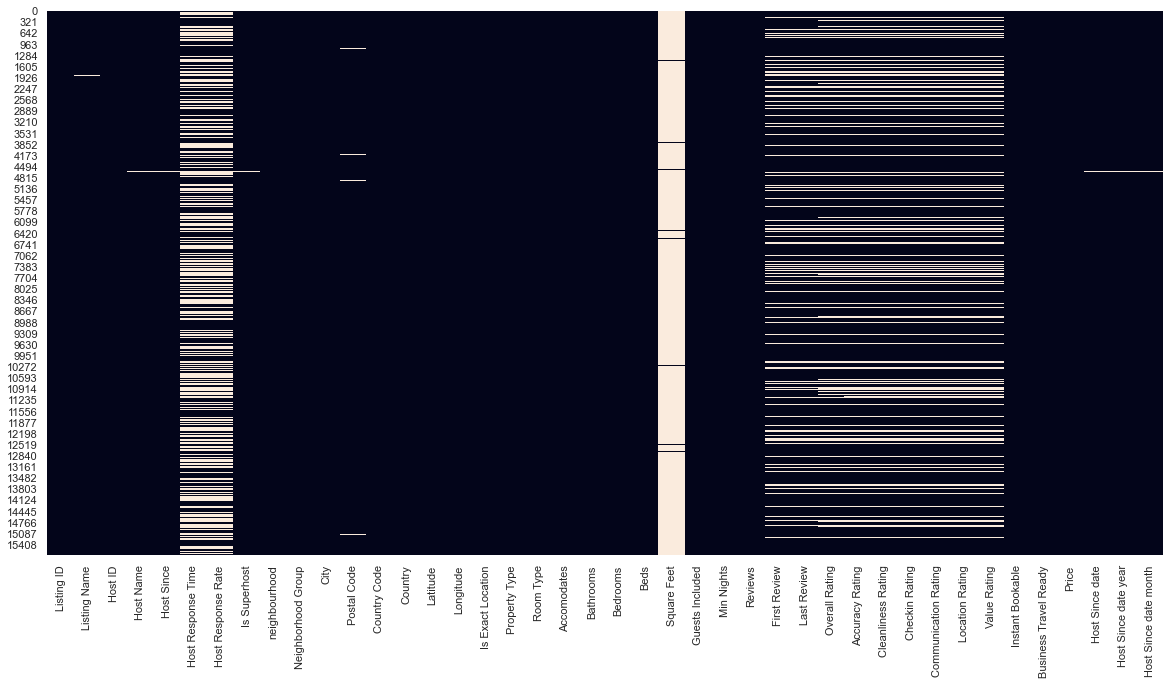

In [47]:
plt.figure(figsize=(20,10))
sns.heatmap(dataset.isna(),cbar=False)
plt.show()

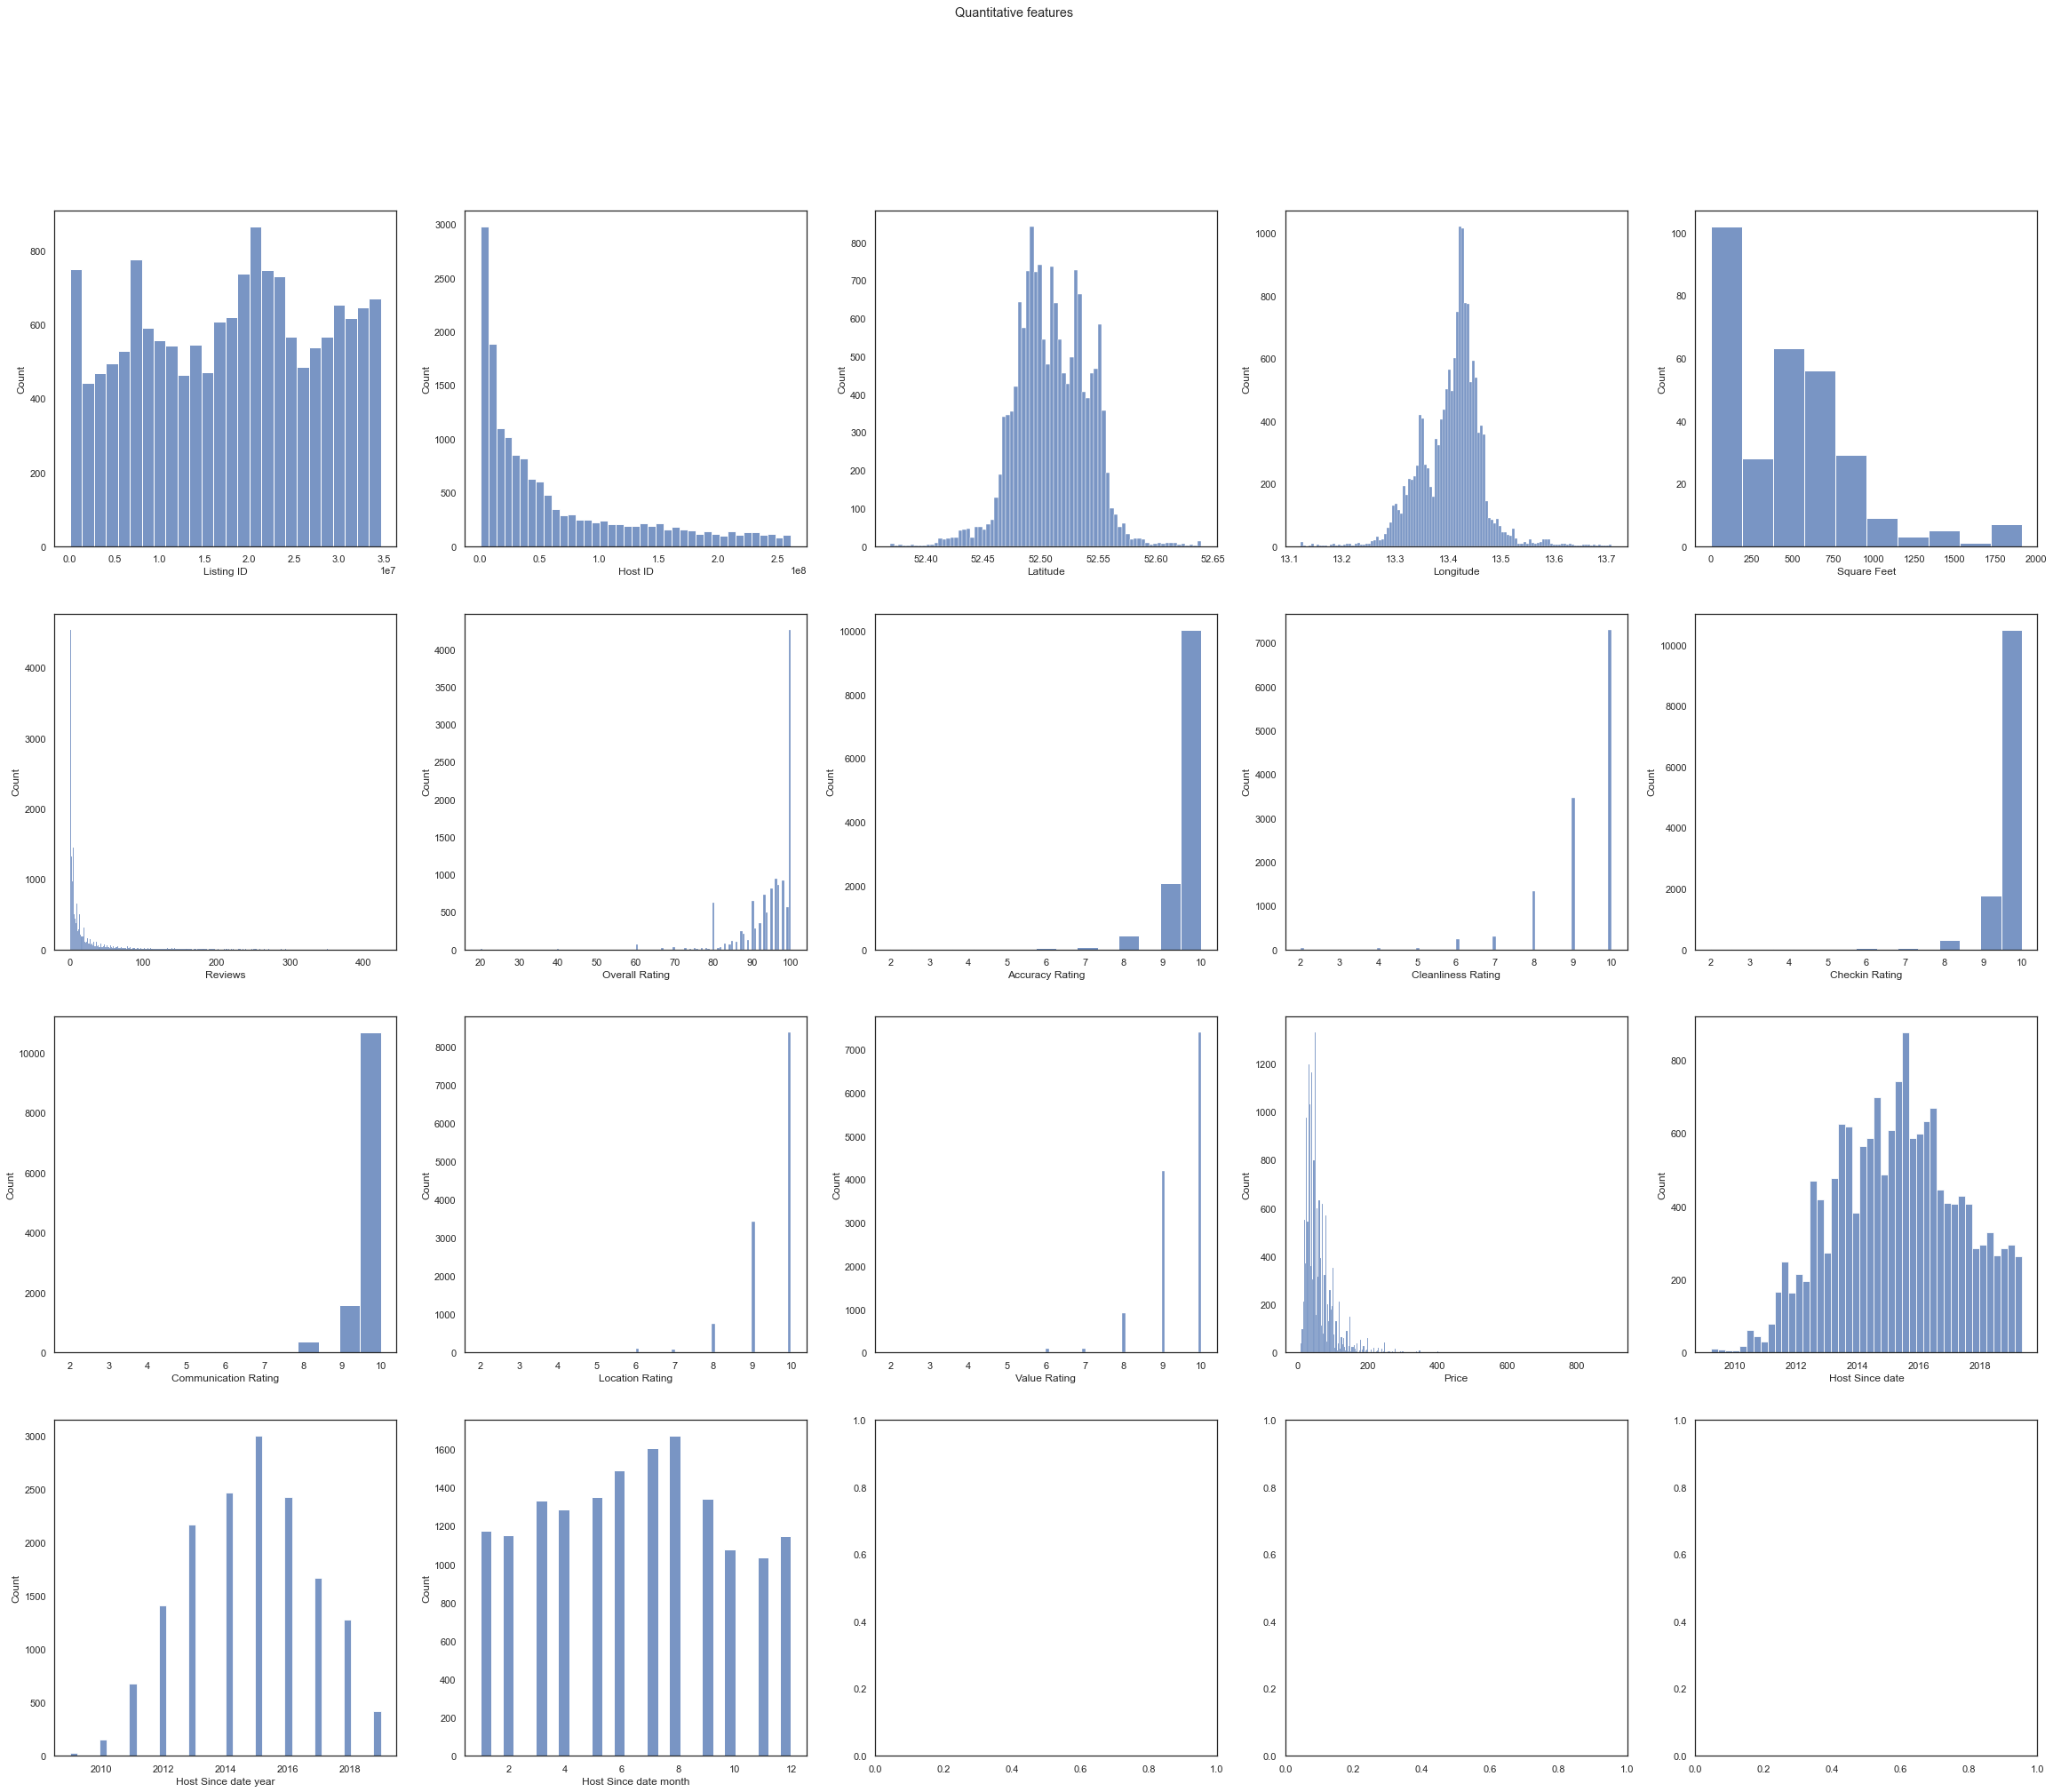

In [62]:
numerical_dataset = dataset.select_dtypes(exclude=['object'])

fig, axes = plt.subplots(4,5, figsize=(8*5,8*4))
for i,col in enumerate(numerical_dataset):
    sns.histplot(dataset[col], ax=axes[i//5,i%5])
fig.suptitle("Quantitative features")
plt.show()

<a href="#top">back to top</a>

<a name="analysis_per_col">
    
### Feature analysis

#### Listing ID

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable represents an id, then it can't be used
</div>

<a href="#top">back to top</a>

#### Listing Name

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable represents a name, as we don't want to create biases in our model, we won't use it
</div>

<a href="#top">back to top</a>

#### Host ID

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable represents an id, then it can't be used
</div>

<a href="#top">back to top</a>

#### Host Name

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable represents a name, as we don't want to create biases in our model, we won't use it
</div>

<a href="#top">back to top</a>

#### Host Since

In [33]:
missing_values_rate_display("Host Since", dataset)

Missing value for Host Since columns: 0.134% (21/15692)


In [11]:
dataset["Host Since date"] = pd.to_datetime(dataset["Host Since"])
dataset["Host Since date year"] = dataset["Host Since date"].dt.year
dataset["Host Since date month"] = dataset["Host Since date"].dt.month

In [12]:
new_train = dataset[["Host Since date year","Price"]].dropna()
new_train["Host Since date year"] = new_train["Host Since date year"].astype("int16")
new_train.describe()

,Host Since date year,Price
count,15662.000000,15662.000000
mean,2014.783425,60.366364
std,2.048661,48.852450
min,2009.000000,8.000000
25%,2013.000000,32.000000
50%,2015.000000,49.000000
75%,2016.000000,70.000000
max,2019.000000,900.000000


In [45]:
new_train = dataset[["Host Since date month","Price"]].dropna()
new_train["Host Since date month"] = new_train["Host Since date month"].astype("int16")
new_train.describe()

,Host Since date month,Price
count,15662.000000,15662.000000
mean,6.444005,60.366364
std,3.275121,48.852450
min,1.000000,8.000000
25%,4.000000,32.000000
50%,7.000000,49.000000
75%,9.000000,70.000000
max,12.000000,900.000000


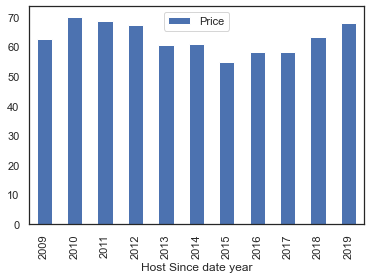

In [15]:
pd.DataFrame(new_train.groupby(["Host Since date year"])["Price"].mean()).plot.bar()
plt.show()

<div class="alert alert-block alert-info">
<b>Rq:</b> Il y a-t-il un sens à regarder depuis quand le propriétaire existe sur airbnb ?  
Hyp: Un propriétaire récent pourrait surévaluer ou sous-évaluer (plus probable) la valeur de son bien</div>

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Host Response Time

In [34]:
missing_values_rate_display("Host Response Time", dataset)

Missing value for Host Response Time columns: 45.087% (7075/15692)


In [18]:
dataset[["Host Response Time","Price"]].dropna().groupby(["Host Response Time"])["Price"].mean()

Host Response Time
a few days or more    62.427793
within a day          62.788403
within a few hours    66.585933
within an hour        68.459220
Name: Price, dtype: float64

In [19]:
new_train_time_host = dataset[["Host Response Time","Price"]].dropna()
pivot_table = dataset.pivot_table(
    index=["Host Response Time"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)
pivot_table

,min,max,mean,median
,Price,Price,Price,Price
Host Response Time,,,,
a few days or more,13.0,720.0,62.427793,50.0
within a day,8.0,900.0,62.788403,50.0
within a few hours,8.0,900.0,66.585933,50.0
within an hour,8.0,650.0,68.459220,52.0
All,8.0,900.0,66.523234,50.0


In [20]:
encoder = OrdinalEncoder()
dataset[["Host Response Time Encoded"]] = encoder.fit_transform(dataset[["Host Response Time"]])

NameError: name 'OrdinalEncoder' is not defined

<AxesSubplot:>

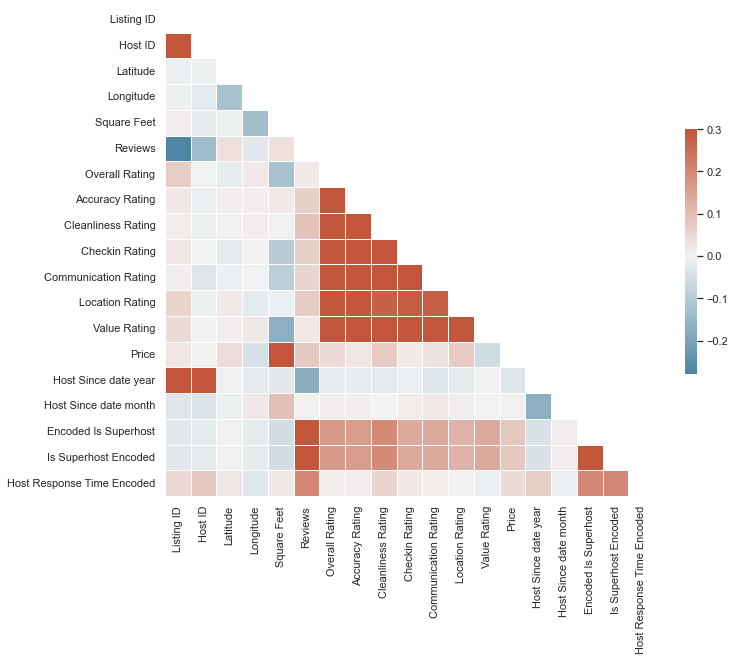

In [114]:
corr = dataset.corr()
display_corr_matrix(corr)

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Host Response Rate

In [36]:
missing_values_rate_display("Host Response Rate", dataset)

Missing value for Host Response Rate columns: 45.087% (7075/15692)


<AxesSubplot:xlabel='Host Response Rate'>

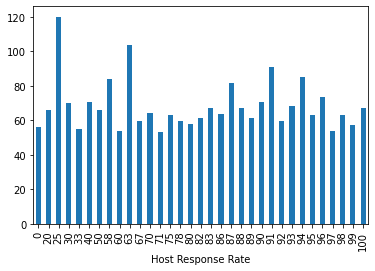

In [76]:
new_train_rate = trainset[["Host Response Rate","Price"]].dropna()
new_train_rate = new_train_rate.drop(new_train_rate[new_train_rate["Host Response Rate"] == "*"].index)
new_train_rate["Host Response Rate"] = new_train_rate["Host Response Rate"].apply(lambda x:x[:-1]).astype("int")
new_train_rate.groupby(["Host Response Rate"])["Price"].mean().plot.bar()

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Is Superhost

In [37]:
missing_values_rate_display("Is Superhost", dataset)

Missing value for Is Superhost columns: 0.147% (23/15692)


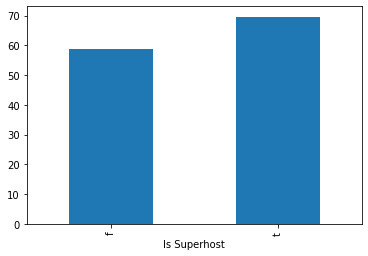

In [90]:
trainset.groupby(["Is Superhost"])["Price"].mean().plot.bar()
plt.show()

In [104]:
encoder = OrdinalEncoder()
trainset[["Is Superhost Encoded"]] = encoder.fit_transform(trainset[["Is Superhost"]])

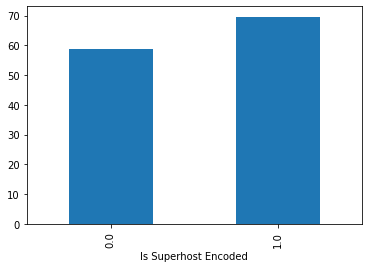

In [105]:
trainset[["Is Superhost"]]
trainset.groupby(["Is Superhost Encoded"])["Price"].mean().plot.bar()
plt.show()

<AxesSubplot:>

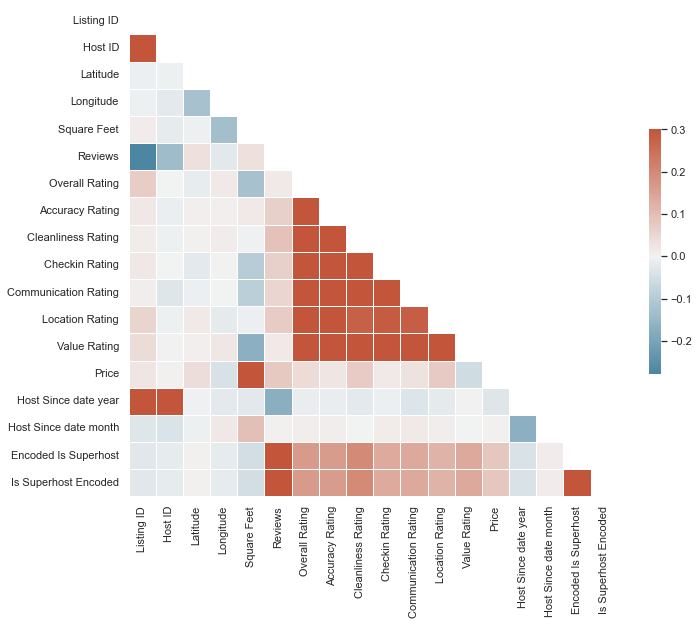

In [109]:
corr = trainset.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
new_train_time_host = trainset[["Host Response Time","Price"]].dropna()
pivot_table = trainset.pivot_table(
    index=["Host Response Time"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)
pivot_table

<AxesSubplot:title={'center':'Price'}, xlabel='[Is Superhost]'>

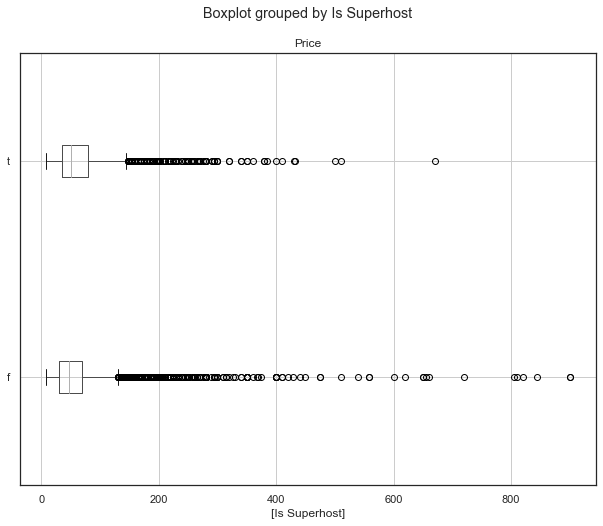

In [48]:
train_neigh = trainset[["Is Superhost",'Price']]
train_neigh.boxplot(by = 'Is Superhost', figsize=(10, 8), vert=False)

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### neighbourhood
=> quartier

In [38]:
missing_values_rate_display("neighbourhood", dataset)

Missing value for neighbourhood columns: 0.000% (0/15692)


In [124]:
trainset.apply(lambda x: x.loc["neighbourhood"]==x.loc["Neighborhood Group"], axis=1).mean()

0.2673336732092786

In [133]:
trainset["neighbourhood"].unique().shape[0]

63

In [134]:
new_train_time_host = trainset[["neighbourhood","Price"]].dropna()
pivot_table = trainset.pivot_table(
    index=["neighbourhood"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)
pivot_table

,min,max,mean,median
,Price,Price,Price,Price
neighbourhood,,,,
*,9.0,295.0,54.098522,40.0
Adlershof,14.0,110.0,48.631579,30.0
Alt-HohenschÃ¶nhausen,17.0,125.0,44.375000,38.0
Alt-Treptow,15.0,279.0,54.349593,45.0
Altglienicke,17.0,120.0,46.588235,30.0
...,...,...,...,...
Wilhelmstadt,30.0,290.0,80.250000,56.5
Wilmersdorf,13.0,650.0,67.739264,50.0


In [143]:
trainset["neighbourhood"].value_counts()

NeukÃ¶lln                2364
Prenzlauer Berg          2012
Kreuzberg                1946
Friedrichshain           1814
Mitte                    1403
                         ... 
Wannsee                    12
Friedrichshagen            12
Buckow                      9
Karow                       9
FranzÃ¶sisch Buchholz       6
Name: neighbourhood, Length: 63, dtype: int64

<BarContainer object of 10 artists>

<Figure size 720x720 with 0 Axes>

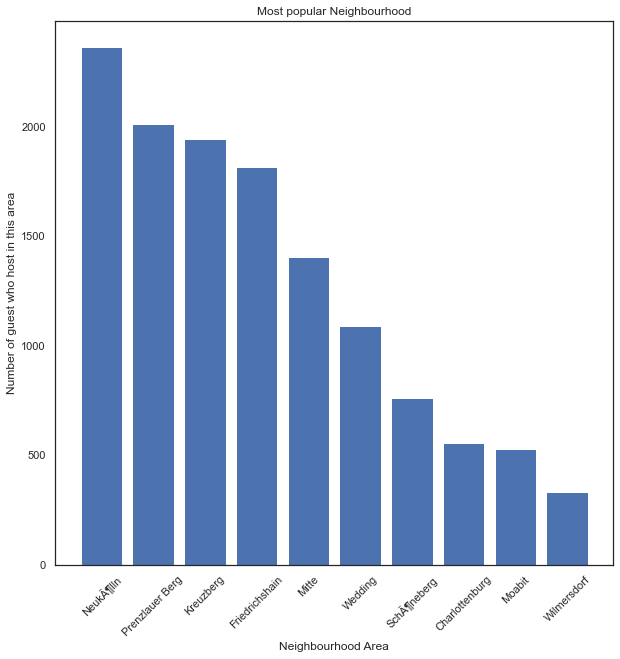

In [53]:
plt.figure(figsize = (10,10))
data = trainset.neighbourhood.value_counts()[:10]
plt.figure(figsize=(10,10))
x = data.index
y = data.values

plt.title("Most popular Neighbourhood")
plt.xlabel("Neighbourhood Area")
plt.ylabel("Number of guest who host in this area")
plt.xticks(rotation=45)
plt.bar(x,y)

In [54]:
import category_encoders as ce

neighborhood_group_df_X = trainset[["neighbourhood"]]
neighborhood_group_df_y = trainset[ "Price"]
encoder = ce.LeaveOneOutEncoder(cols=["neighbourhood"])
encoder.fit(neighborhood_group_df_X, neighborhood_group_df_y)
df_n = encoder.transform(neighborhood_group_df_X)
df_n["Price"] = trainset[ "Price"]
df_n.corr()

,neighbourhood,Price
neighbourhood,1.000000,0.217256
Price,0.217256,1.000000


C:\Users\flavi\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 159 (\x9f) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


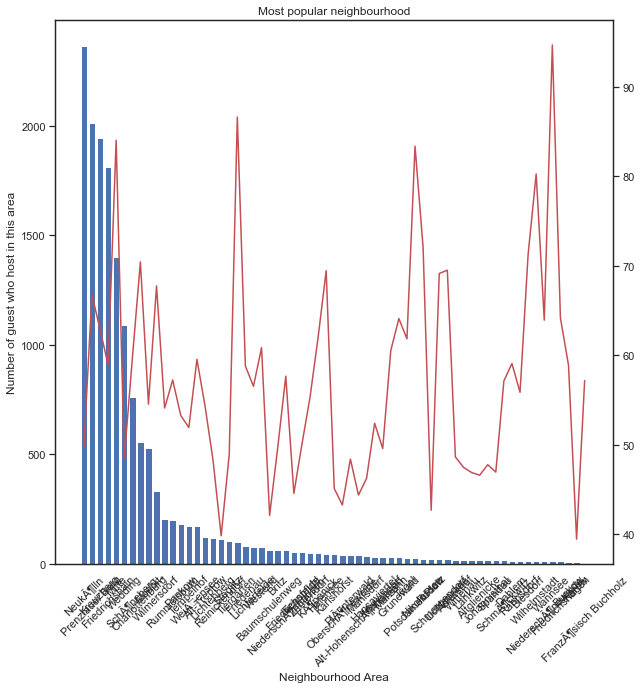

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
data = trainset["neighbourhood"].value_counts()
mean_price = trainset[["neighbourhood", "Price"]].groupby(["neighbourhood"])["Price"].mean().reindex(data.index)

x = data.index
y = data.values

plt.title("Most popular neighbourhood")
plt.xlabel("Neighbourhood Area")
plt.ylabel("Number of guest who host in this area")
plt.xticks(rotation=45)
plt.bar(x,y)

ax2=ax.twinx()

plt.plot(mean_price.index, mean_price.values, c="r")

plt.show()

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Neighborhood Group

In [40]:
missing_values_rate_display("Neighborhood Group", dataset)

Missing value for Neighborhood Group columns: 0.000% (0/15692)


In [135]:
new_train_time_host = trainset[["Neighborhood Group","Price"]].dropna()
pivot_table = trainset.pivot_table(
    index=["Neighborhood Group"],
    values=["Price"],
    aggfunc=["min","max","mean","median"],
    margins=True
)
pivot_table

,min,max,mean,median
,Price,Price,Price,Price
Neighborhood Group,,,,
Charlottenburg-Wilm.,8.0,650.0,68.653447,51.0
Friedrichshain-Kreuzberg,8.0,450.0,61.033439,50.0
Lichtenberg,11.0,475.0,51.028846,42.0
Marzahn - Hellersdorf,13.0,276.0,57.188976,45.0
Mitte,8.0,845.0,66.632840,50.0
NeukÃ¶lln,10.0,660.0,49.642915,40.0
Pankow,9.0,900.0,64.868985,50.0
Reinickendorf,8.0,340.0,45.247706,36.0


<AxesSubplot:title={'center':'Price'}, xlabel='[Neighborhood Group]'>

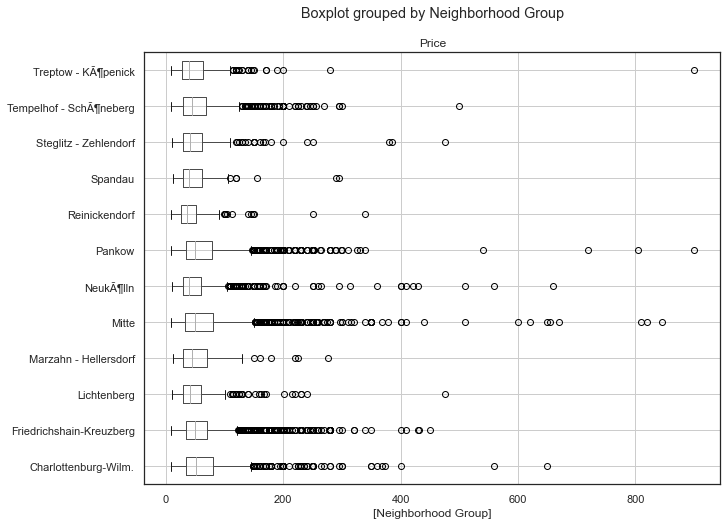

In [47]:
train_neigh = trainset[['Neighborhood Group','Price']]
train_neigh.boxplot(by = 'Neighborhood Group', figsize=(10, 8), vert=False)

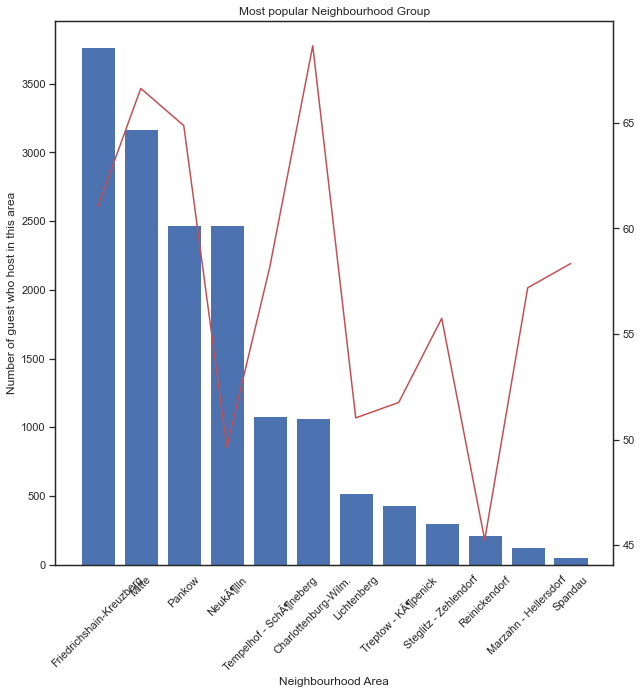

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
data = trainset["Neighborhood Group"].value_counts()
mean_price = trainset[["Neighborhood Group", "Price"]].groupby(["Neighborhood Group"])["Price"].mean().reindex(data.index)

x = data.index
y = data.values

plt.title("Most popular Neighbourhood Group")
plt.xlabel("Neighbourhood Area")
plt.ylabel("Number of guest who host in this area")
plt.xticks(rotation=45)
plt.bar(x,y)

ax2=ax.twinx()

plt.plot(mean_price.index, mean_price.values, c="r")

plt.show()

In [145]:
trainset["Neighborhood Group"].value_counts()

Friedrichshain-Kreuzberg    3768
Mitte                       3174
Pankow                      2473
NeukÃ¶lln                   2470
Tempelhof - SchÃ¶neberg     1081
Charlottenburg-Wilm.        1065
Lichtenberg                  520
Treptow - KÃ¶penick          435
Steglitz - Zehlendorf        302
Reinickendorf                218
Marzahn - Hellersdorf        127
Spandau                       59
Name: Neighborhood Group, dtype: int64

In [69]:
missing_values_rate_display("Neighborhood Group", trainset)

Missing value for Neighborhood Group columns: 0.000%


In [132]:
trainset["Neighborhood Group"].unique().shape[0]

12

In [155]:
encoded_trainset = pd.get_dummies(trainset,prefix=['Neighborhood Group'], columns = ['Neighborhood Group'], drop_first=True)
encoded_trainset.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,...,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price,Neighborhood Group_Friedrichshain-Kreuzberg,Neighborhood Group_Lichtenberg,Neighborhood Group_Marzahn - Hellersdorf,Neighborhood Group_Mitte,Neighborhood Group_NeukÃ¶lln,Neighborhood Group_Pankow,Neighborhood Group_Reinickendorf,Neighborhood Group_Spandau,Neighborhood Group_Steglitz - Zehlendorf,Neighborhood Group_Tempelhof - SchÃ¶neberg,Neighborhood Group_Treptow - KÃ¶penick
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Berlin,10437.0,DE,Germany,52.54652,13.41792,t,Apartment,Private room,2,1.0,...,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0,0,0,0,0,0,1,0,0,0,0,0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Berlin,13187.0,DE,Germany,52.56512,13.42214,t,Apartment,Entire home/apt,2,1.0,...,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0,0,0,0,0,0,1,0,0,0,0,0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Berlin,10439.0,DE,Germany,52.54741,13.42521,t,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0,0,0,0,0,0,1,0,0,0,0,0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Berlin,10245,DE,Germany,52.50958,13.45144,t,Apartment,Private room,2,1.0,...,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0,1,0,0,0,0,0,0,0,0,0,0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Berlin,10405.0,DE,Germany,52.52995,13.41558,t,Apartment,Private room,3,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0,0,0,0,0,0,1,0,0,0,0,0


In [18]:
# Mean Target Encoding
data_neigh = trainset.groupby(["Neighborhood Group"])["Price"].mean()
data_neigh

Neighborhood Group
Charlottenburg-Wilm.        68.653447
Friedrichshain-Kreuzberg    61.033439
Lichtenberg                 51.028846
Marzahn - Hellersdorf       57.188976
Mitte                       66.632840
NeukÃ¶lln                   49.642915
Pankow                      64.868985
Reinickendorf               45.247706
Spandau                     58.338983
Steglitz - Zehlendorf       55.741722
Tempelhof - SchÃ¶neberg     58.167748
Treptow - KÃ¶penick         51.758621
Name: Price, dtype: float64

In [24]:
trainset["Neighborhood Group encoded"] = trainset["Neighborhood Group"].replace(data_neigh.index, data_neigh.values)

In [27]:
trainset[["Neighborhood Group encoded", "Price"]].corr()

,Neighborhood Group encoded,Price
Neighborhood Group encoded,1.000000,0.134236
Price,0.134236,1.000000


In [34]:
neighborhood_group_df_X

,Neighborhood Group
0,Pankow
1,Pankow
2,Pankow
3,Friedrichshain-Kreuzberg
4,Pankow
...,...
15687,Friedrichshain-Kreuzberg
15688,NeukÃ¶lln
15689,Mitte
15690,Tempelhof - SchÃ¶neberg


In [43]:
neighborhood_group_df_X = trainset[["Neighborhood Group"]]
neighborhood_group_df_y = trainset[ "Price"]
encoder = ce.LeaveOneOutEncoder(cols=["Neighborhood Group"])
encoder.fit(neighborhood_group_df_X, neighborhood_group_df_y)
df_n = encoder.transform(neighborhood_group_df_X)
df_n["Price"] = trainset[ "Price"]
df_n.corr()

,Neighborhood Group,Price
Neighborhood Group,1.000000,0.134236
Price,0.134236,1.000000


In [ ]:
hey are probably using "leave one out encoding" to refer to Owen Zhang's strategy.

From here

The encoded column is not a conventional dummy variable, but instead is the mean response over all rows for this categorical level, excluding the row itself. This gives you the advantage of having a one-column representation of the categorical while avoiding direct response leakage

This picture expresses the idea well.

<AxesSubplot:>

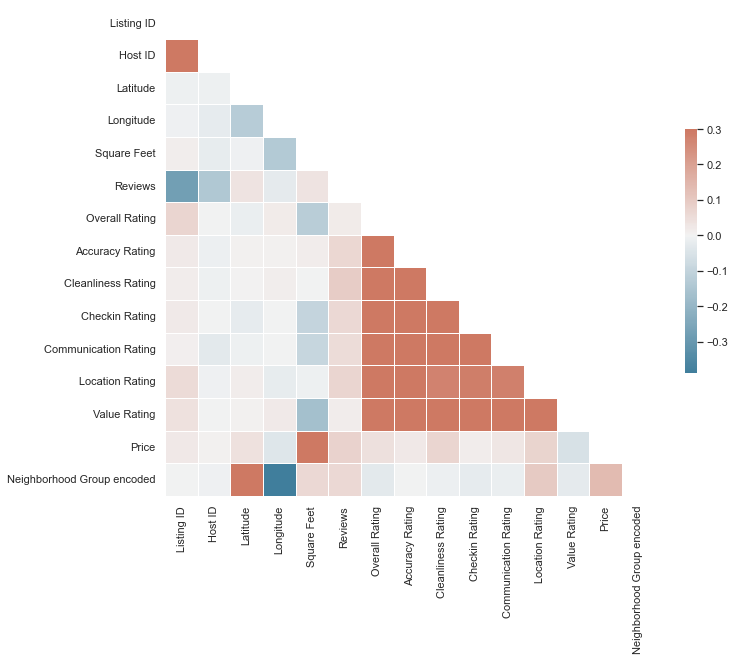

In [25]:
corr = trainset.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### City

In [41]:
missing_values_rate_display("City", dataset)

Missing value for City columns: 0.006% (1/15692)


In [43]:
print("Possible values of the 'City' feature:\n",dataset["City"].unique())

Possible values of the 'City' feature:
 ['Berlin' '*' nan]


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

<a href="#top">back to top</a>

#### Postal Code

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Country Code

In [31]:
missing_values_rate_display("Country Code", dataset)

Missing value for Country Code columns: 0.000% (0/15692)


In [27]:
print("Possible values of the 'Country Code' feature:\n",dataset["Country Code"].unique())

Possible values of the 'Country Code' feature:
 ['DE']


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

<a href="#top">back to top</a>

#### Country

In [42]:
missing_values_rate_display("Country", dataset)

Missing value for Country columns: 0.000% (0/15692)


In [26]:
print("Possible values of the 'Country' feature:\n",dataset.Country.unique())

Possible values of the 'Country' feature:
 ['Germany']


<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable can't be used because it contains only one possible value
</div>

<a href="#top">back to top</a>

#### Latitude

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Longitude

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Is Exact Location

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Property Type

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Room Type

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Accomodates

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Bathrooms

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Bedrooms

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Beds

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Square Feet

In [23]:
missing_values_rate_display("Square Feet", dataset)

Missing value for Square Feet columns: 98.069%


<div class="alert alert-block alert-info">
<b>Rq:</b> We could use other features to estimate its value, but it would create dependence between variables</div>

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable can't be use, it contains too much missing values
</div>

<a href="#top">back to top</a>

#### Guests Included

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Min Nights

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Reviews

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### First Review

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Last Review

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Overall Rating

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Accuracy Rating

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Cleanliness Rating

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Checkin Rating

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Communication Rating

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Location Rating

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Value Rating

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Instant Bookable

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

#### Business Travel Ready

<div class="alert alert-block alert-success">
<b>Conlusion:</b> This variable would not be util for the next step
</div>

<a href="#top">back to top</a>

<a name="target_analysis">

### Target analysis

<a href="#top">back to top</a>

<a name="pca">

### PCA

<a href="#top">back to top</a>

<a name="conclusion">

### Conclusion

<div class="alert alert-block alert-success">
On enleve les variables:
- ID/Name:  
Listing ID,Listing Name,Host ID,Host Name  
  
- Une seule valeur possible:  
City,Country Code,Country  
   
- Trop de valeurs manquantes:   
square_feet  
</div>

<a href="#top">back to top</a>

<a name="preprocessing">

## Preprocessing
---

<a name="split">

### Split

<a href="#top">back to top</a>

<a name="missing_values">

### Missing values

<a href="#top">back to top</a>

<a name="scaling">

### Scaling

<a href="#top">back to top</a>

<a name="outliers">

### Outliers

<a href="#top">back to top</a>

<a name="cat_feat">

### Categorical features

<a href="#top">back to top</a>

<a name="feature_eng">

### Feature engineering

<a href="#top">back to top</a>

<a name="modeling">

## Modeling

In [ ]:
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

<a href="#top">back to top</a>

<a name="feature_selection">

### Feature selection

<a href="#top">back to top</a>

<a name="model_selection">

### Model selection

<a href="#top">back to top</a>

<a name="scoring">

## Scoring
---

<a href="#top">back to top</a>